In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/Shareddrives/shared_students/geophysics_22/

/content/drive/Shareddrives/shared_students/geophysics_22


In [10]:
ls

17_wave_propagation.ipynb        harmonics/
geophysics_student_lists.gsheet  Oct_18_22/


In [11]:
!git clone https://github.com/PongthepGeo/introduction_geophysics_22.git

Cloning into 'introduction_geophysics_22'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 1), reused 23 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [5]:
cd /content/drive/Shareddrives/shared_students/geophysics_22/introduction_geophysics_22


/content/drive/Shareddrives/shared_students/geophysics_22/introduction_geophysics_22


In [3]:
pip install --user git+https://github.com/devitocodes/devito.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/devitocodes/devito.git to /tmp/pip-req-build-8109wgg6
  Running command git clone -q https://github.com/devitocodes/devito.git /tmp/pip-req-build-8109wgg6
  Created wheel for devito: filename=devito-4.7.1+181.gdff0791b9-py3-none-any.whl size=502640 sha256=fb7217ad1639fea77e334a8d93fa2158f6aaa24698df63d05ca7336a1d65ef16
  Stored in directory: /tmp/pip-ephem-wheel-cache-k2u7lpok/wheels/dc/0d/17/288e933ecc39424f520fc03349b9178cf4ae82e4fdda526c85
Successfully built devito


In [11]:
mkdir snapshots

Operator `initdamp` ran in 0.01 s
INFO:Devito:Operator `initdamp` ran in 0.01 s


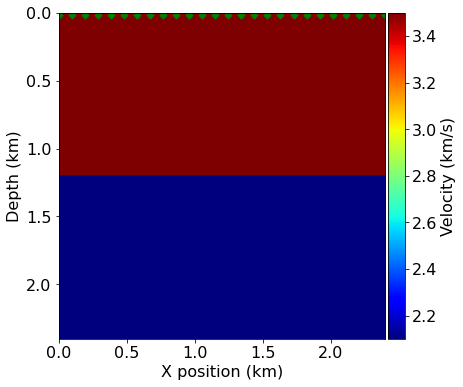

factor is 16
t_sub


Operator `Kernel` ran in 0.82 s
INFO:Devito:Operator `Kernel` ran in 0.82 s
Operator `Kernel` ran in 0.86 s
INFO:Devito:Operator `Kernel` ran in 0.86 s


Saving snaps file
Dimensions: nz = 601, nx = 601


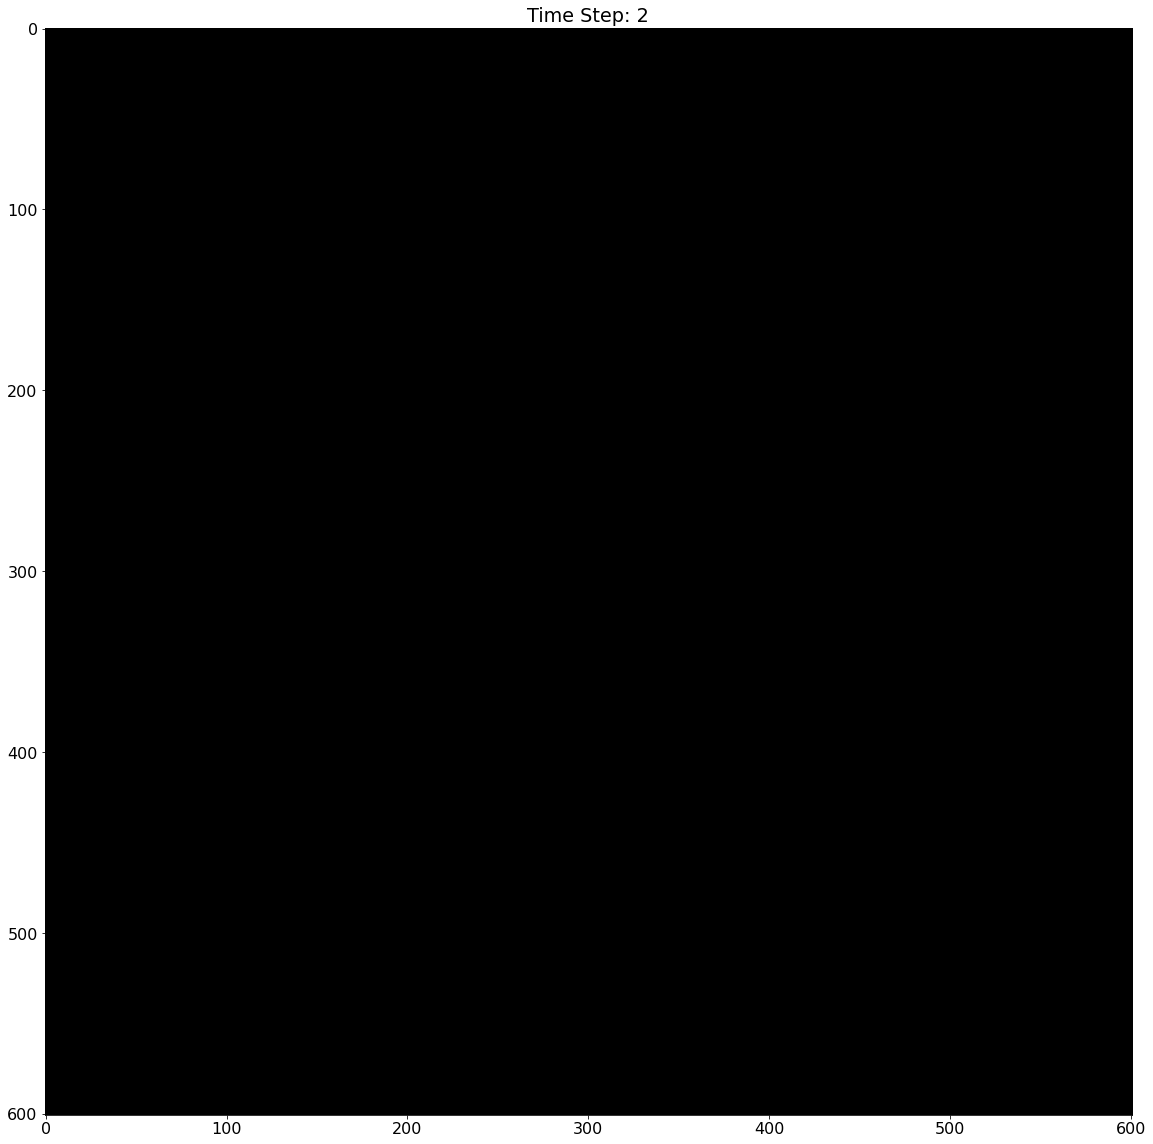

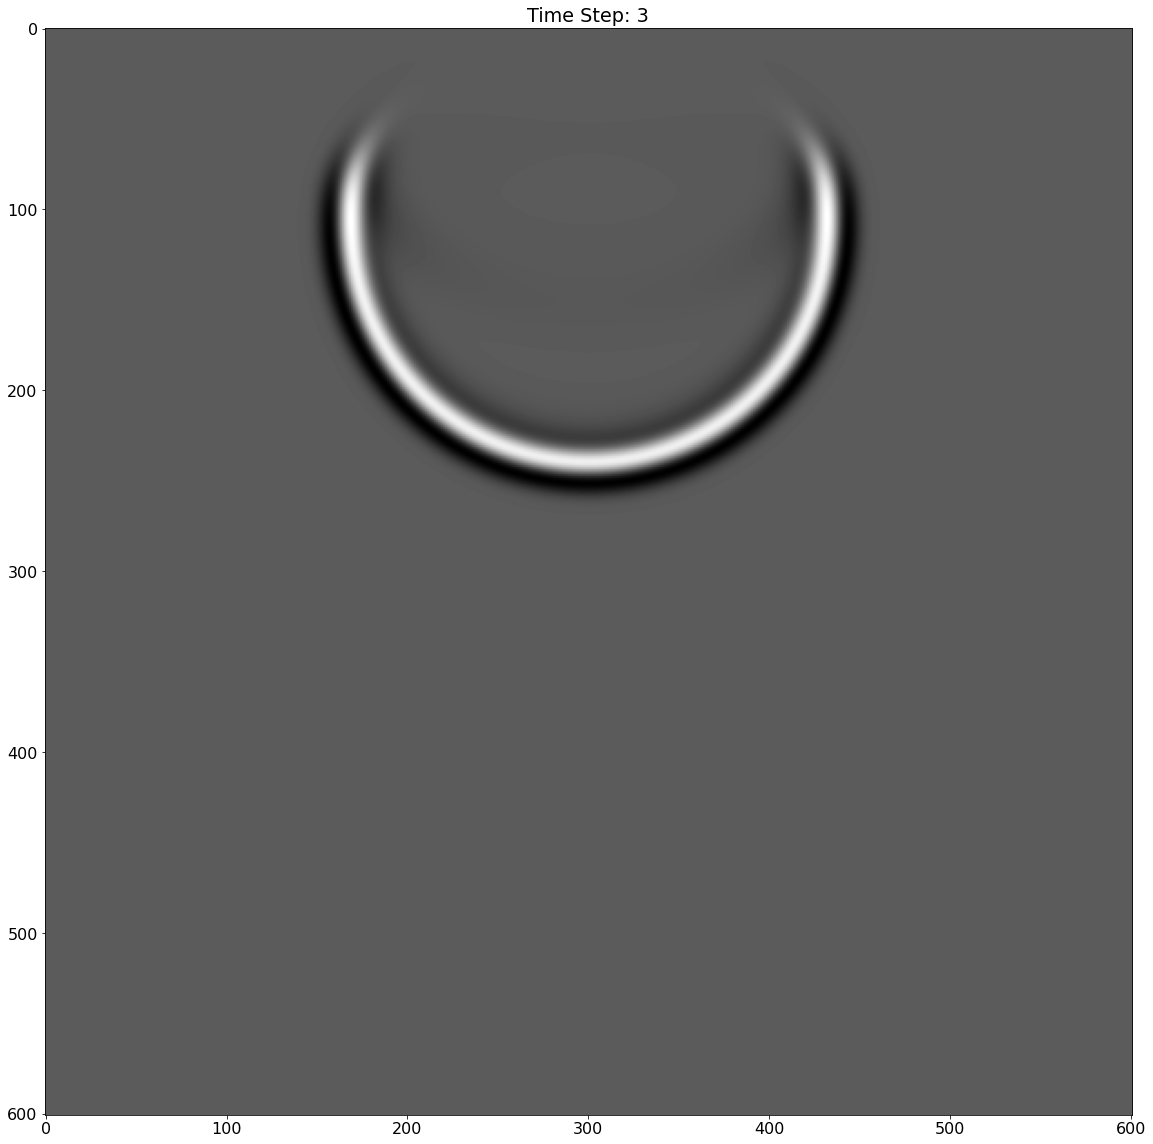

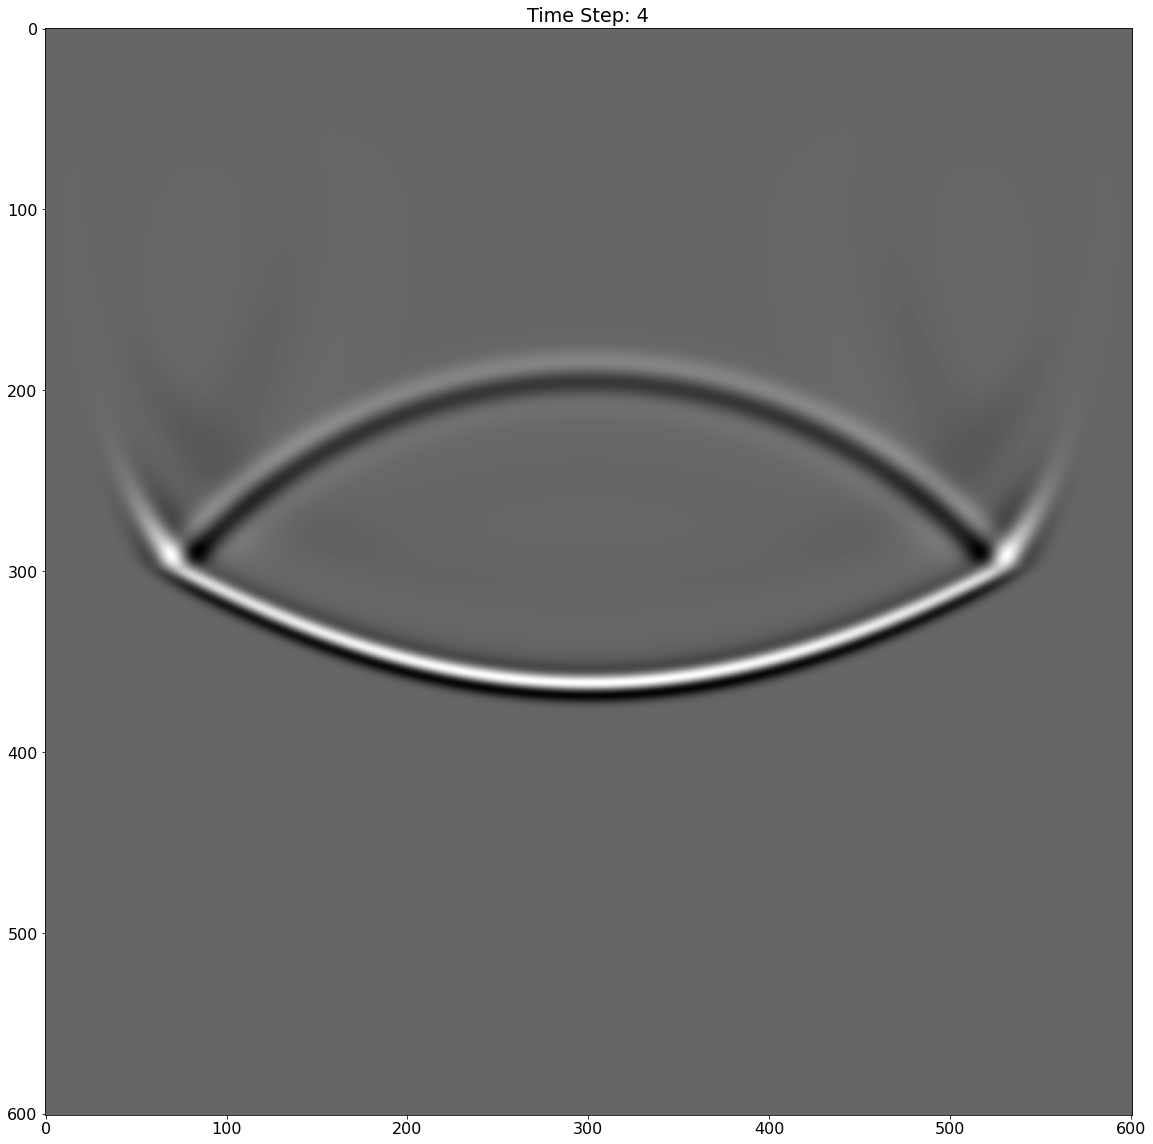

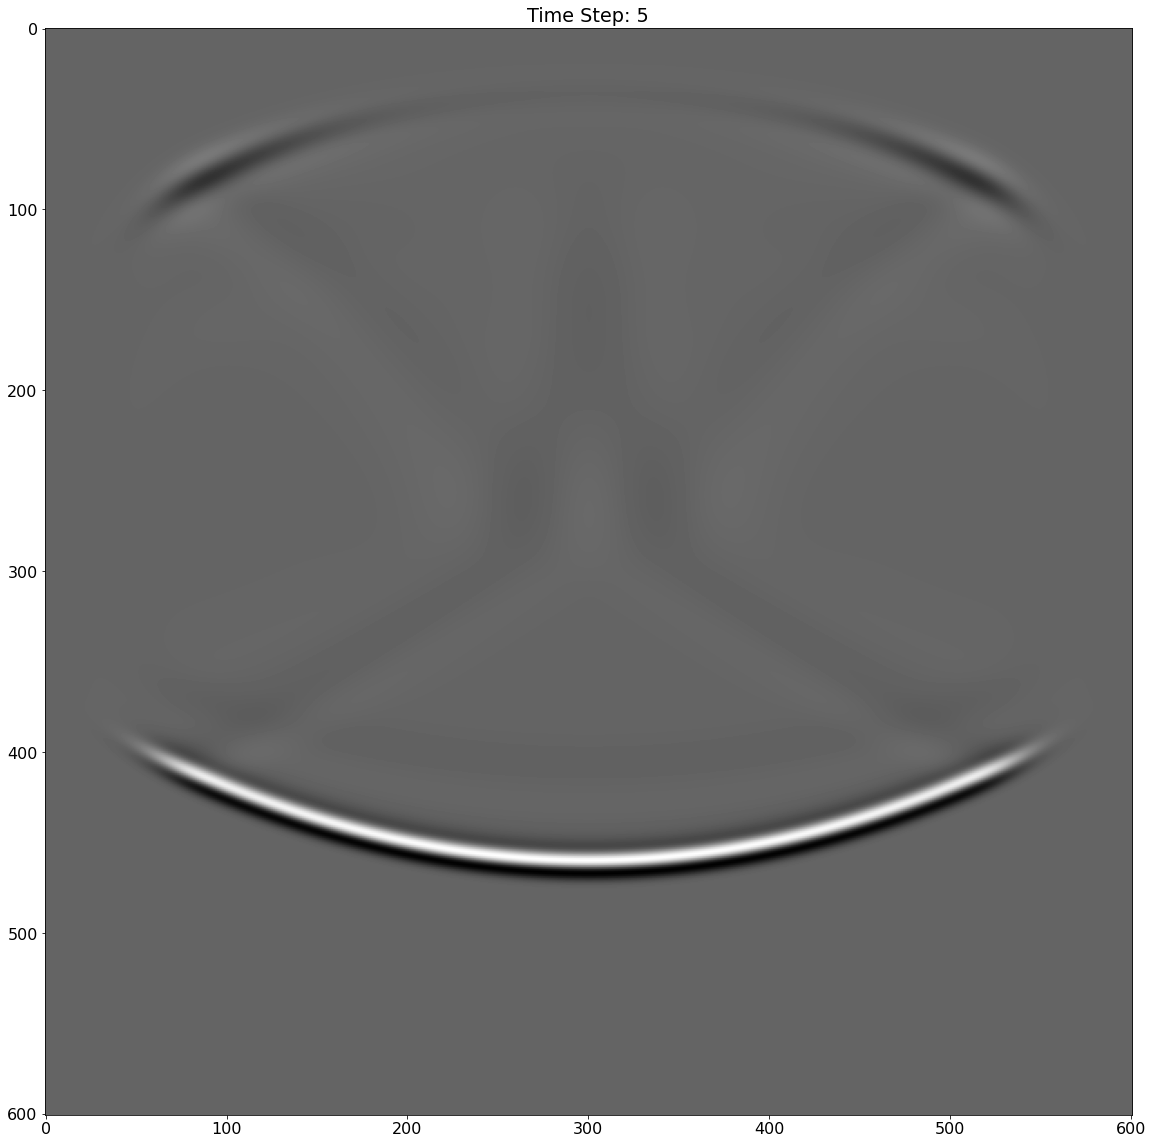

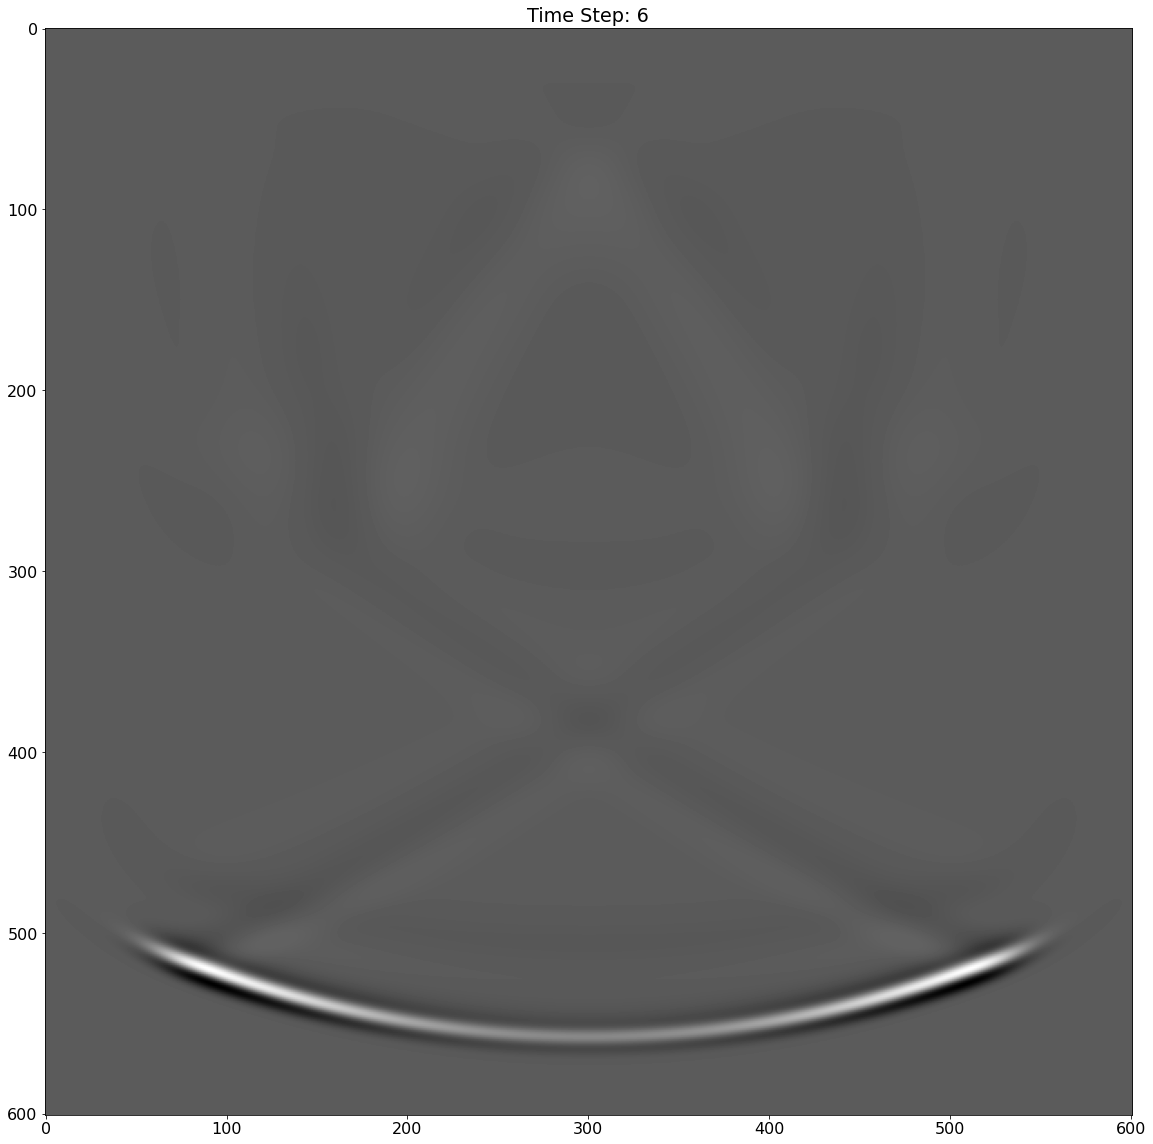

In [12]:
import sys
sys.path.append('Libs') 
import seismic as S
#-----------------------------------------------------------------------------------------#
import numpy as np
import matplotlib.pyplot as plt 
#-----------------------------------------------------------------------------------------#
from examples.seismic import Receiver, RickerSource, Model, plot_velocity, TimeAxis
from devito import TimeFunction, Eq, solve, Operator, ConditionalDimension
from scipy import ndimage
#-----------------------------------------------------------------------------------------#

'''
step 1: create velocity model
'''

# NOTE define model size
nx = 401; nz = 401; nb = 100
shape = (nx, nz)
spacing = (6., 6.) # grid spacing
origin = (0., 0.)
# NOTE velocity
v = np.empty(shape, dtype=np.float32)
v[:, int(nx/2):] = 2.1 # top
v[:, :int(nx/2)] = 3.5 # bottom
# v[150:170, 50:70] = 4.6. # box
# NOTE plot velocity, we need to rotate 90 for visualing purpose. Devito uses different coordinate from plt.imshow.
# S.plot_velocity(v, 'Two Layers')
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, space_order=10, nbl=100, bcs='damp')

'''
step 2: create layout for source and geophone acquisition
'''

t0 = 0.  # Simulation starts a t=0
tn = 1400.  # Simulation lasts tn milliseconds
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps
# NOTE source position
f0 = 0.02  # Source peak frequency (0.020 kHz)
src = RickerSource(
	name='src',
	grid=model.grid,
	f0=f0,
	time_range=time_range)  
# source layout
# src.coordinates.data[0, :] = np.array(model.domain_size) * .5 
src.coordinates.data[0, :] = (np.array(model.domain_size) - (nb*2*6)) * .5 
src.coordinates.data[0, -1] = 50 - nb*6  
# NOTE reciever positions
rec = Receiver(
	name='rec',
	grid=model.grid,
	npoint=101,
	time_range=time_range)  # new
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # depth is 20
depth = rec.coordinates.data[:, 1]  
# NOTE plot velocity model and acquisition
plot_velocity(model, source=src.coordinates.data, receiver=rec.coordinates.data[::4, :])

'''
step 3: locate point source and compute stencil
'''

# NOTE locate source
vnx = nx+nb*2 # Used for reshaping model
vnz = nz+nb*2
nsnaps = 103 
# nsnaps = 203 
factor = round(nt / nsnaps) 
print(f"factor is {factor}")
# NOTE define finite difference (mathematical method to solve wave equation)
time_subsampled = ConditionalDimension('t_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=4, save=nsnaps, time_dim=time_subsampled)
print(time_subsampled)
# NOTE inject point source
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4)
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(
	field=u.forward,
	expr=src * dt**2 / model.m,
	offset=model.nbl)
rec_term = rec.interpolate(expr=u, offset=model.nbl)

'''
step 4: solve wave equation
'''

op1 = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)  # usual operator
op2 = Operator([stencil] + src_term + [Eq(usave, u)] + rec_term, subs=model.spacing_map)  # operator with snapshots
op1(time=nt - 2, dt=model.critical_dt)  # run only for comparison
u.data.fill(0.)
op2(time=nt - 2, dt=model.critical_dt)

'''
step 5: save snapshot as .npy
'''

print('Saving snaps file')
print('Dimensions: nz = {:d}, nx = {:d}'.format(nz + 2 * nb, nx + 2 * nb))
filename = 'snapshots/snaps2.bin'
usave.data.tofile(filename)
fobj = open(filename, 'rb')
snaps = np.fromfile(fobj, dtype=np.float32)
snaps = np.reshape(snaps, (nsnaps, vnx, vnz))
fobj.close()

'''
step 6: load computed snapshots from .npy files and plot wave propagation in each time step.
'''

plt.rcParams['figure.figsize'] = (20, 20)  # Increases figure size
imcnt = 1 # Image counter for plotting
plot_num = 5 # Number of images to plot
# plot_num = 10 # Number of images to plot
snap = 'snapshots/timestep_'
for i in range(0, plot_num):
	imcnt = imcnt + 1
	ind = i * int(nsnaps/plot_num)
	np.save(snap + str(imcnt), np.transpose(snaps[ind, :, :]))

imcnt = 1 # Image counter for plotting
for i in range(0, plot_num):
	imcnt = imcnt + 1
	ind = i * int(nsnaps/plot_num)
	dummy = np.load(snap + str(imcnt) + '.npy')
	plt.imshow(dummy, cmap='gray')
	plt.title('Time Step: ' + str(imcnt))
	# plt.xlim(40, 200)
	# plt.ylim(200, 0)
	# save_file = ('timestep_' + str(imcnt))
	# plt.savefig('image_out/' + save_file + '.svg', format='svg', bbox_inches='tight', transparent=True, pad_inches=0)
	plt.show()